In [1]:
import json

import awkward as ak
import numpy as np
import hist
from awkward._nplikes.dispatch import nplike_of_obj
from awkward._nplikes.shape import unknown_length
from awkward._nplikes.virtual import VirtualArray
from matplotlib import pyplot as plt
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea.nanoevents.mapping.uproot import UprootSourceMapping

UprootSourceMapping._debug = False


# def virtualize(array, form_key, access_log):
#     def generate():
#         print(f"Generating buffer {form_key}")
#         access_log["data"].append(form_key)
#         return array
        
#     if "offsets" in form_key:
#         shape = array.shape
#     else:
#         shape = (unknown_length,)
        
#     return VirtualArray(nplike_of_obj(array), shape, array.dtype, generate)


# def make_events(file, schemaclass=NanoAODSchema):
#     access_log = {"data": [], "shapes": []}
#     events = NanoEventsFactory.from_root(
#         {file: "Events"}, mode="eager", schemaclass=schemaclass, metadata={"dataset": file.removesuffix(".root")}
#     ).events()
#     behavior = events.behavior
#     attrs = events.attrs
#     form, length, container = ak.to_buffers(events)
#     new_form = events.layout.form_with_key_path()
#     new_container = {}
#     for old_key, new_key in zip(form.expected_from_buffers().keys(), new_form.expected_from_buffers().keys()):
#         new_container[new_key] = container[old_key]
#     with open("form.json", "w") as f:
#         json.dump(form.to_dict(), f, indent=2)
#     virtual_container = {key: virtualize(buffer, key, access_log) for key, buffer in new_container.items()}
#     breakpoint()
#     events = ak.from_buffers(new_form, length, virtual_container, behavior=behavior)
#     events.attrs["@original_array"] = events
#     return events, access_log


def make_events(file, schemaclass=NanoAODSchema):
    access_log = []
    events = NanoEventsFactory.from_root(
        {file: "Events"},
        mode="virtual",
        schemaclass=schemaclass,
        metadata={"dataset": file.removesuffix(".root")},
        access_log=access_log
    ).events()
    events.attrs["@original_array"] = events
    return events, access_log

/Users/iason/Dropbox/work/coffea_dev/coffea/src/coffea/nanoevents/schemas/edm4hep.py:7: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
root_file = "DYto2E.root"
events, access_log = make_events(root_file)
access_log

[]

In [3]:
ak.materialize(events)

<NanoEventsArray [<NanoAOD event>, ...] type='1000 * event'>

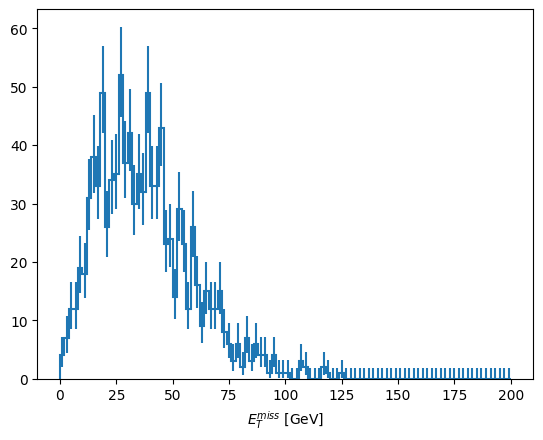

['MET_pt']

In [4]:
events, access_log = make_events(root_file)

q1_hist = hist.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]").Double().fill(events.MET.pt)

q1_hist.plot1d(flow="none")
plt.show()
access_log

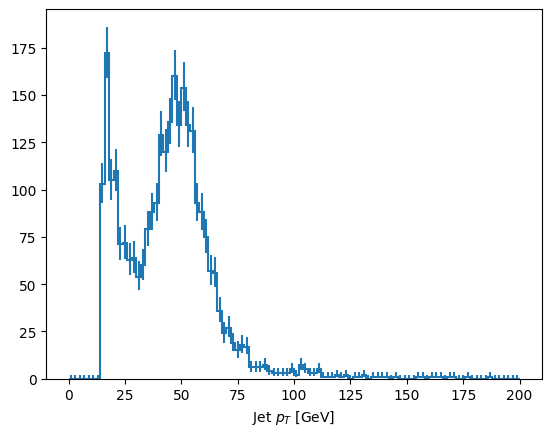

['nJet', 'Jet_pt']

In [5]:
events, access_log = make_events(root_file)

q2_hist = hist.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]").Double().fill(ak.flatten(events.Jet.pt))

q2_hist.plot1d(flow="none")
plt.show()
access_log

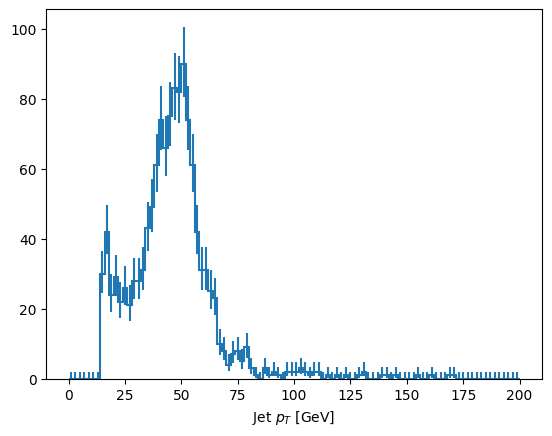

['nJet', 'Jet_eta', 'Jet_pt']

In [6]:
events, access_log = make_events(root_file)

q3_hist = (
    hist.Hist.new.Reg(100, 0, 200, name="ptj", label="Jet $p_{T}$ [GeV]")
    .Double()
    .fill(ak.flatten(events.Jet[abs(events.Jet.eta) < 1].pt))
)

q3_hist.plot1d(flow="none")
plt.show()
access_log

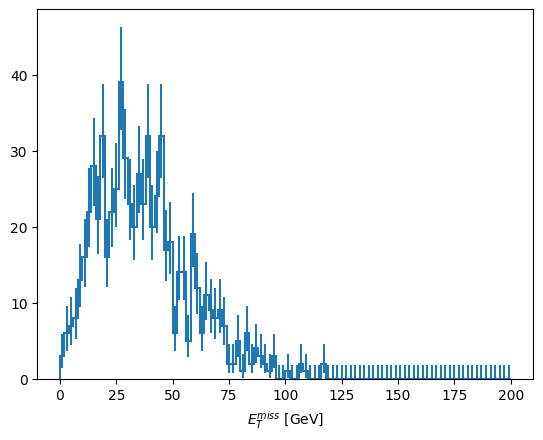

['nJet', 'Jet_pt', 'MET_pt']

In [7]:
events, access_log = make_events(root_file)

has2jets = ak.sum(events.Jet.pt > 40, axis=1) >= 2
q4_hist = (
    hist.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]").Double().fill(events[has2jets].MET.pt)
)

q4_hist.plot1d(flow="none")
plt.show()
access_log

/Users/iason/miniforge3/envs/ak-uproot/lib/python3.12/site-packages/mplhep/utils.py:486: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


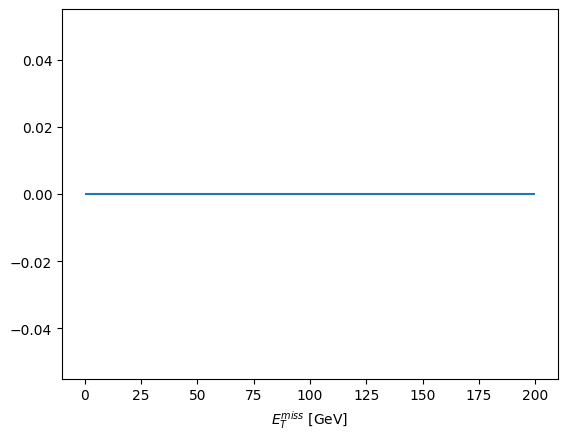

['nMuon',
 'Muon_pt',
 'Muon_phi',
 'Muon_eta',
 'Muon_mass',
 'Muon_charge',
 'MET_pt']

In [8]:
events, access_log = make_events(root_file)

mupair = ak.combinations(events.Muon, 2, fields=["mu1", "mu2"])
pairmass = (mupair.mu1 + mupair.mu2).mass
goodevent = ak.any(
    (pairmass > 60) & (pairmass < 120) & (mupair.mu1.charge == -mupair.mu2.charge),
    axis=1,
)
q5_hist = (
    hist.Hist.new.Reg(100, 0, 200, name="met", label="$E_{T}^{miss}$ [GeV]").Double().fill(events[goodevent].MET.pt)
)

q5_hist.plot1d(flow="none")
plt.show()
access_log

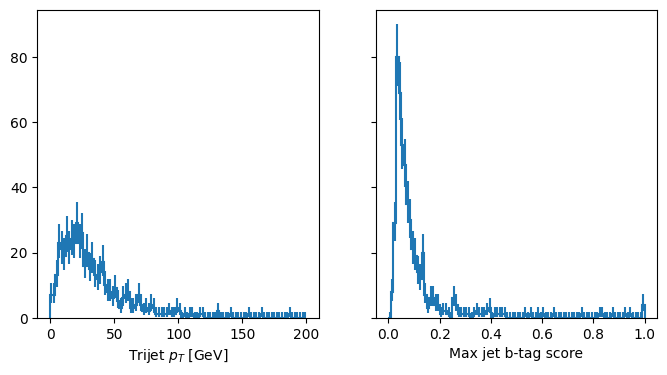

['nJet', 'Jet_phi', 'Jet_pt', 'Jet_eta', 'Jet_mass', 'Jet_btagDeepFlavB']

In [9]:
events, access_log = make_events(root_file)

jets = ak.zip(
    {k: getattr(events.Jet, k) for k in ["x", "y", "z", "t", "btagDeepFlavB"]},
    with_name="LorentzVector",
    behavior=events.Jet.behavior,
)
jets["btag"] = jets.btagDeepFlavB
trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])
trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
trijet = ak.flatten(trijet[ak.singletons(ak.argmin(abs(trijet.p4.mass - 172.5), axis=1))])
maxBtag = np.maximum(
    trijet.j1.btag,
    np.maximum(
        trijet.j2.btag,
        trijet.j3.btag,
    ),
)
q6_hists = {
    "trijetpt": hist.Hist.new.Reg(100, 0, 200, name="pt3j", label="Trijet $p_{T}$ [GeV]").Double().fill(trijet.p4.pt),
    "maxbtag": hist.Hist.new.Reg(100, 0, 1, name="btag", label="Max jet b-tag score").Double().fill(maxBtag),
}

out = q6_hists
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
out["trijetpt"].plot1d(ax=ax1, flow="none")
out["maxbtag"].plot1d(ax=ax2, flow="none")
plt.show()
access_log

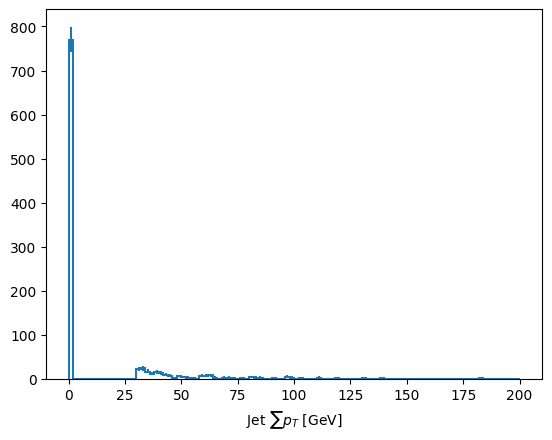

['nMuon',
 'Muon_pt',
 'nJet',
 'Jet_pt',
 'Jet_phi',
 'Jet_eta',
 'Muon_phi',
 'Muon_eta',
 'nElectron',
 'Electron_pt',
 'Electron_phi',
 'Electron_eta']

In [10]:
events, access_log = make_events(root_file)

cleanjets = events.Jet[
    ak.all(events.Jet.metric_table(events.Muon[events.Muon.pt > 10]) >= 0.4, axis=2)
    & ak.all(
        events.Jet.metric_table(events.Electron[events.Electron.pt > 10]) >= 0.4,
        axis=2,
    )
    & (events.Jet.pt > 30)
]
q7_hist = (
    hist.Hist.new.Reg(100, 0, 200, name="sumjetpt", label=r"Jet $\sum p_{T}$ [GeV]")
    .Double()
    .fill(ak.sum(cleanjets.pt, axis=1))
)

q7_hist.plot1d(flow="none")
plt.show()
access_log

['nElectron', 'Electron_charge', 'nMuon', 'Muon_charge', 'Electron_pt', 'Electron_phi', 'Electron_eta', 'Electron_mass', 'Muon_pt', 'Muon_phi', 'Muon_eta', 'Muon_mass', 'MET_pt', 'MET_phi']


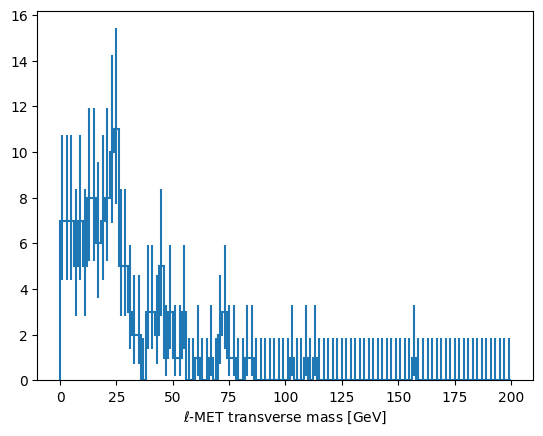

['nElectron',
 'Electron_charge',
 'nMuon',
 'Muon_charge',
 'Electron_pt',
 'Electron_phi',
 'Electron_eta',
 'Electron_mass',
 'Muon_pt',
 'Muon_phi',
 'Muon_eta',
 'Muon_mass',
 'MET_pt',
 'MET_phi']

In [11]:
events, access_log = make_events(root_file)

events["Electron", "pdgId"] = -11 * events.Electron.charge
events["Muon", "pdgId"] = -13 * events.Muon.charge
events["leptons"] = ak.with_name(
    ak.concatenate(
        [events.Electron, events.Muon],
        axis=1,
    ),
    "PtEtaPhiMCandidate",
)
events = events[ak.num(events.leptons) >= 3]
pair = ak.argcombinations(events.leptons, 2, fields=["l1", "l2"])
pair = pair[(events.leptons[pair.l1].pdgId == -events.leptons[pair.l2].pdgId)]

pair = pair[
    ak.singletons(
        ak.argmin(
            abs((events.leptons[pair.l1] + events.leptons[pair.l2]).mass - 91.2),
            axis=1,
        )
    )
]

events = events[ak.num(pair) > 0]
pair = pair[ak.num(pair) > 0][:, 0]

l3 = ak.local_index(events.leptons)
l3 = l3[(l3 != pair.l1) & (l3 != pair.l2)]
l3 = l3[ak.argmax(events.leptons[l3].pt, axis=1, keepdims=True)]
l3 = events.leptons[l3][:, 0]

mt = np.sqrt(2 * l3.pt * events.MET.pt * (1 - np.cos(events.MET.delta_phi(l3))))
q8_hist = hist.Hist.new.Reg(100, 0, 200, name="mt", label=r"$\ell$-MET transverse mass [GeV]").Double().fill(mt)

q8_hist.plot1d(flow="none")
print(access_log)
plt.show()
access_log

In [12]:
from collections import defaultdict
import numba
from coffea import processor
from coffea.nanoevents.methods import candidate


@numba.njit
def find_4lep(events_leptons, builder):
    """Search for valid 4-lepton combinations from an array of events * leptons {charge, ...}

    A valid candidate has two pairs of leptons that each have balanced charge
    Outputs an array of events * candidates {indices 0..3} corresponding to all valid
    permutations of all valid combinations of unique leptons in each event
    (omitting permutations of the pairs)
    """
    for leptons in events_leptons:
        builder.begin_list()
        nlep = len(leptons)
        for i0 in range(nlep):
            for i1 in range(i0 + 1, nlep):
                if leptons[i0].charge + leptons[i1].charge != 0:
                    continue
                for i2 in range(nlep):
                    for i3 in range(i2 + 1, nlep):
                        if len({i0, i1, i2, i3}) < 4:
                            continue
                        if leptons[i2].charge + leptons[i3].charge != 0:
                            continue
                        builder.begin_tuple(4)
                        builder.index(0).integer(i0)
                        builder.index(1).integer(i1)
                        builder.index(2).integer(i2)
                        builder.index(3).integer(i3)
                        builder.end_tuple()
        builder.end_list()

    return builder


class FancyDimuonProcessor(processor.ProcessorABC):
    def process(self, events):
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        mass_axis = hist.axis.Regular(300, 0, 300, name="mass", label=r"$m_{\mu\mu}$ [GeV]")
        pt_axis = hist.axis.Regular(300, 0, 300, name="pt", label=r"$p_{T,\mu}$ [GeV]")

        h_nMuons = hist.Hist(
            dataset_axis,
            hist.axis.IntCategory(range(6), name="nMuons", label="Number of good muons"),
            storage="weight",
            label="Counts",
        )
        h_m4mu = hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ1 = hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_mZ2 = hist.Hist(dataset_axis, mass_axis, storage="weight", label="Counts")
        h_ptZ1mu1 = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")
        h_ptZ1mu2 = hist.Hist(dataset_axis, pt_axis, storage="weight", label="Counts")

        cutflow = defaultdict(int)

        dataset = events.metadata["dataset"]
        muons = ak.zip(
            {
                "pt": events.Muon_pt,
                "eta": events.Muon_eta,
                "phi": events.Muon_phi,
                "mass": events.Muon_mass,
                "charge": events.Muon_charge,
                "isolation": events.Muon_pfRelIso03_all,
            },
            with_name="PtEtaPhiMCandidate",
            behavior=candidate.behavior,
        )

        # make sure they are sorted by transverse momentum
        muons = muons[ak.argsort(muons.pt, axis=1)]

        cutflow["all events"] += len(muons)

        # impose some quality and minimum pt cuts on the muons
        muons = muons[(muons.pt > 5) & (muons.isolation < 0.2)]
        cutflow["at least 4 good muons"] += ak.sum(ak.num(muons) >= 4)
        h_nMuons.fill(dataset=dataset, nMuons=ak.num(muons))

        # reduce first axis: skip events without enough muons
        muons = muons[ak.num(muons) >= 4]

        # find all candidates with helper function
        fourmuon = find_4lep(ak.materialize(muons), ak.ArrayBuilder()).snapshot()
        if ak.all(ak.num(fourmuon) == 0):
            # skip processing as it is an EmptyArray
            return {
                "nMuons": h_nMuons,
                "cutflow": {dataset: cutflow},
            }
        fourmuon = [muons[fourmuon[idx]] for idx in "0123"]
        fourmuon = ak.zip(
            {
                "z1": ak.zip(
                    {
                        "lep1": fourmuon[0],
                        "lep2": fourmuon[1],
                        "p4": fourmuon[0] + fourmuon[1],
                    }
                ),
                "z2": ak.zip(
                    {
                        "lep1": fourmuon[2],
                        "lep2": fourmuon[3],
                        "p4": fourmuon[2] + fourmuon[3],
                    }
                ),
            }
        )

        cutflow["at least one candidate"] += ak.sum(ak.num(fourmuon) > 0)

        # require minimum dimuon mass
        fourmuon = fourmuon[(fourmuon.z1.p4.mass > 60.0) & (fourmuon.z2.p4.mass > 20.0)]
        cutflow["minimum dimuon mass"] += ak.sum(ak.num(fourmuon) > 0)

        # choose permutation with z1 mass closest to nominal Z boson mass
        bestz1 = ak.singletons(ak.argmin(abs(fourmuon.z1.p4.mass - 91.1876), axis=1))
        fourmuon = ak.flatten(fourmuon[bestz1])

        h_m4mu.fill(
            dataset=dataset,
            mass=(fourmuon.z1.p4 + fourmuon.z2.p4).mass,
        )
        h_mZ1.fill(
            dataset=dataset,
            mass=fourmuon.z1.p4.mass,
        )
        h_mZ2.fill(
            dataset=dataset,
            mass=fourmuon.z2.p4.mass,
        )
        h_ptZ1mu1.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep1.pt,
        )
        h_ptZ1mu2.fill(
            dataset=dataset,
            pt=fourmuon.z1.lep2.pt,
        )
        return {
            "nMuons": h_nMuons,
            "mass": h_m4mu,
            "mass_z1": h_mZ1,
            "mass_z2": h_mZ2,
            "pt_z1_mu1": h_ptZ1mu1,
            "pt_z1_mu2": h_ptZ1mu2,
            "cutflow": {dataset: cutflow},
        }

    def postprocess(self, accumulator):
        pass

In [13]:
import time

events_zz, access_log_zz = make_events("ZZTo4mu.root", schemaclass=BaseSchema)
events_higgs, access_log_higgs = make_events("SMHiggsToZZTo4L.root", schemaclass=BaseSchema)

tstart = time.time()
res_zz = FancyDimuonProcessor().process(events_zz)
print(100 * "-")
rest_higgs = FancyDimuonProcessor().process(events_higgs)
elapsed = time.time() - tstart
print(elapsed)

out = {"ZZto4mu": res_zz, "SMHiggsToZZTo4L": rest_higgs}
out, access_log_zz, access_log_higgs

----------------------------------------------------------------------------------------------------
0.7068049907684326


({'ZZto4mu': {'nMuons': Hist(
     StrCategory(['ZZTo4mu'], growth=True, name='dataset', label='Primary dataset'),
     IntCategory([0, 1, 2, 3, 4, 5], name='nMuons', label='Number of good muons'),
     storage=Weight()) # Sum: WeightedSum(value=499574, variance=499574) (WeightedSum(value=500000, variance=500000) with flow),
   'mass': Hist(
     StrCategory(['ZZTo4mu'], growth=True, name='dataset', label='Primary dataset'),
     Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=26423, variance=26423) (WeightedSum(value=32736, variance=32736) with flow),
   'mass_z1': Hist(
     StrCategory(['ZZTo4mu'], growth=True, name='dataset', label='Primary dataset'),
     Regular(300, 0, 300, name='mass', label='$m_{\\mu\\mu}$ [GeV]'),
     storage=Weight()) # Sum: WeightedSum(value=32712, variance=32712) (WeightedSum(value=32736, variance=32736) with flow),
   'mass_z2': Hist(
     StrCategory(['ZZTo4mu'], growth=True, name='dataset

In [14]:
nevt = (
    out["ZZto4mu"]["cutflow"]["ZZTo4mu"]["all events"]
    + out["SMHiggsToZZTo4L"]["cutflow"]["SMHiggsToZZTo4L"]["all events"]
)
print("Events/s:", (nevt / elapsed))

scaled = {}
for (name1, h1), (name2, h2) in zip(out["ZZto4mu"].items(), out["SMHiggsToZZTo4L"].items()):
    if isinstance(h1, hist.Hist) and isinstance(h2, hist.Hist):
        scaled[name1] = h1.copy() + h2.copy()

Events/s: 1131815.7206703874


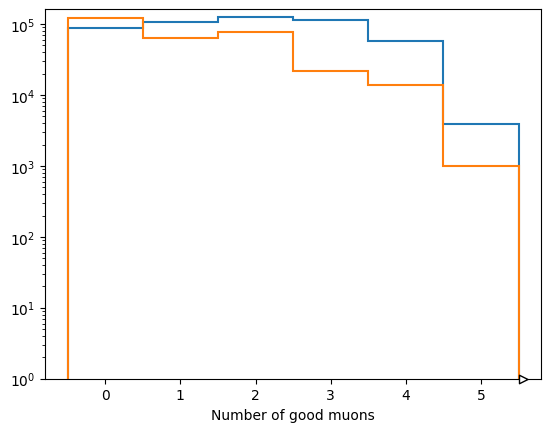

In [15]:
fig, ax = plt.subplots()

scaled["nMuons"].plot1d(ax=ax, overlay="dataset")
ax.set_yscale("log")
ax.set_ylim(1, None)
plt.show()

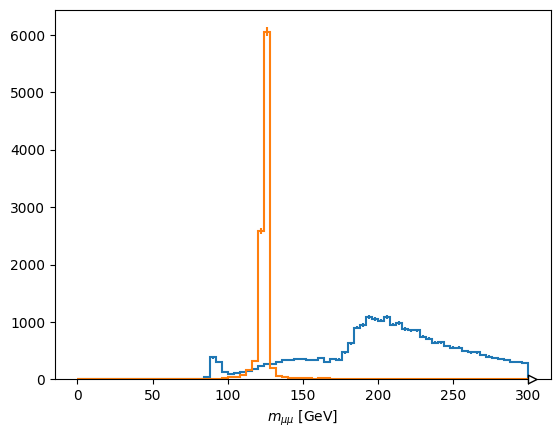

In [16]:
fig, ax = plt.subplots()

scaled["mass"][:, :: hist.rebin(4)].plot1d(ax=ax, overlay="dataset")
plt.show()

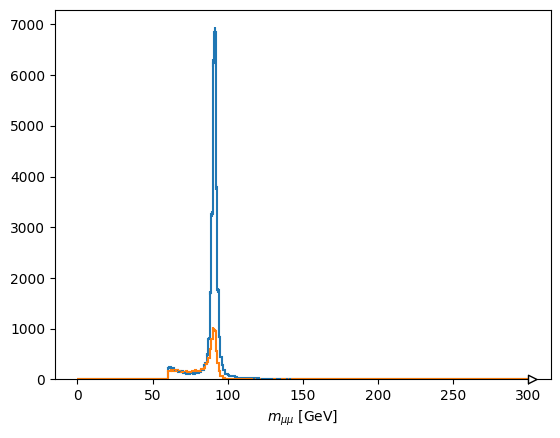

In [17]:
fig, ax = plt.subplots()

scaled["mass_z1"].plot1d(ax=ax, overlay="dataset")
plt.show()

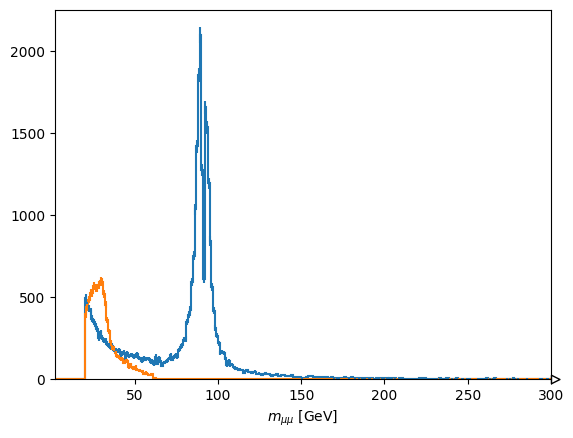

In [18]:
fig, ax = plt.subplots()

scaled["mass_z2"].plot1d(ax=ax, overlay="dataset")
ax.set_xlim(2, 300)
plt.show()

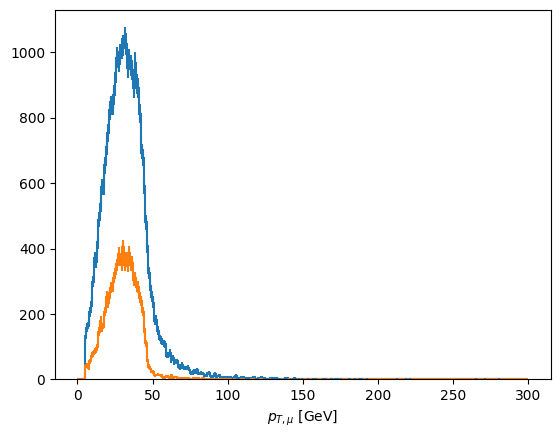

In [19]:
fig, ax = plt.subplots()

scaled["pt_z1_mu1"].plot1d(ax=ax, overlay="dataset")
plt.show()

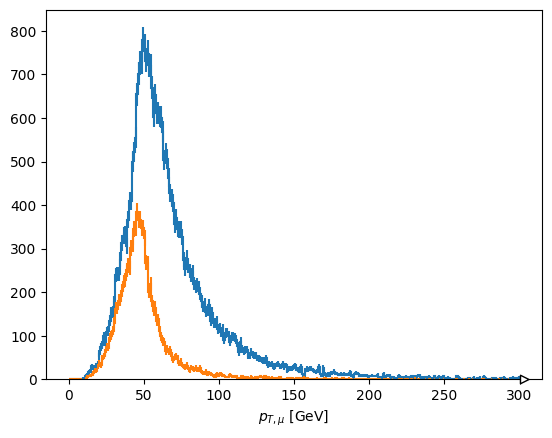

In [20]:
fig, ax = plt.subplots()

scaled["pt_z1_mu2"].plot1d(ax=ax, overlay="dataset")
plt.show()